In [7]:
ls ../data/bulk_RNAseq/

GSE130727_human_EC_Fibs/        GSE58910_human_astrocytes/  senMayo_data/
GSE171663_human_smooth_muscle/  GSE64553_human_fibs/


In [1]:
from pydeseq2.ds import DeseqStats
from pydeseq2.dds import DeseqDataSet
import senepy as sp
import pandas as pd
import os

from gseapy.plot import gseaplot
import gseapy as gp

import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sanbomics.tools import id_map

In [3]:
#function to turn gsea object into dataframe
def gsea_df(pre_res):
    out = []

    for term in list(pre_res.results):
        out.append([term,
                   pre_res.results[term]['fdr'],
                   pre_res.results[term]['es'],
                   pre_res.results[term]['nes']])

    out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
    out_df
    return out_df

In [4]:
#mouse markers
with open('../data/gene_lists/mouse_markers.txt') as f:
    mmarkers = list(f)
mmarkers = [x for x in mmarkers if not x.startswith('#') and ':' in x]
mmarkers = dict(map(lambda x: x.strip().split(':'), mmarkers)) #dict marker:role
mmarkers = list(mmarkers)

In [5]:
#human markers
with open('../data/gene_lists/human_markers.txt') as f:
    hmarkers = list(f)
hmarkers = [x for x in hmarkers if not x.startswith('#') and ':' in x]
hmarkers = dict(map(lambda x: x.strip().split(':'), hmarkers)) #dict marker:role
hmarkers = list(hmarkers)
hmarkers = [x.upper() for x in hmarkers]

In [2]:
#load gene sets for enrichment
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
senmayo_m = [x[0] + x[1:].lower() for x in senmayo]

with open('../data/gene_lists/senGPT.txt') as f:
    sengpt = [x.strip() for x in list(f)]
    sengpt_m = [x[0] + x[1:].lower() for x in sengpt]

In [7]:
mouse_sets = {}

m = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')
for hub in m.hubs:
    name = '.'.join([str(x) for x in hub])
    mouse_sets[name] = [x[0] for x in m.hubs[hub]]
    
mouse_sets['senMayo'] = senmayo_m
mouse_sets['senGPT'] = sengpt_m
mouse_sets['senMarkers'] = mmarkers

In [8]:
human_sets = {}

h = sp.load_hubs(species = 'Human', sig_type = 'cell_type')
for hub in h.hubs:
    name = '.'.join([str(x) for x in hub])
    human_sets[name] = [x[0] for x in h.hubs[hub]]
    
human_sets['senMayo'] = senmayo
human_sets['senGPT'] = sengpt
human_sets['senMarkers'] = hmarkers

In [9]:
#function to filter out genes from a gene_set that were not in the background
def filter_gene_sets(gene_set, background_list):
    new_d = {}
    for entry in gene_set:
        filtered_genes = [x for x in gene_set[entry] if x in background_list]
        new_d[entry] = filtered_genes
        
    return new_d

# EC + fibs

In [ ]:
#4 cell types: WI-38, IMR-90, HUVEC, HAEC

#multiple induction
#RS, IR or doxorubicin, oncogene HRASG12V

In [10]:
paths = os.listdir('../data/bulk_RNAseq/GSE130727_human_EC_Fibs')

paths = ['../data/bulk_RNAseq/GSE130727_human_EC_Fibs/' + x for x in paths]

paths = [x for x in paths if not x.endswith('.tar')]


In [11]:
dater  = {
  "GSM3752521": "HAEC IR- 1",
  "GSM3752522": "HAEC IR- 2",
  "GSM3752523": "HAEC IR+ 1",
  "GSM3752524": "HAEC IR+ 2",
  "GSM3752525": "HAEC IR+ 3",
  "GSM3752526": "HUVEC IR- 1",
  "GSM3752527": "HUVEC IR- 2",
  "GSM3752528": "HUVEC IR- 3",
  "GSM3752529": "HUVEC IR+ 1",
  "GSM3752530": "HUVEC IR+ 2",
  "GSM3752531": "HUVEC IR+ 3",
  "GSM3752532": "IMR-90 PDL15 1",
  "GSM3752533": "IMR-90 PDL15 2",
  "GSM3752534": "IMR-90 IR+ 1",
  "GSM3752535": "IMR-90 IR+ 2",
  "GSM3752536": "IMR-90 PDL52 1",
  "GSM3752537": "IMR-90 PDL52 2",
  "GSM3752538": "WI-38 Dox- 1",
  "GSM3752539": "WI-38 Dox- 2",
  "GSM3752540": "WI-38 Dox+ 1",
  "GSM3752541": "WI-38 Dox+ 2",
  "GSM3752542": "WI-38 EV 1",
  "GSM3752543": "WI-38 EV 2",
  "GSM3752544": "WI-38 HRAS(G12v) 1",
  "GSM3752545": "WI-38 HRAS(G12v) 2",
  "GSM3752546": "WI-38 Dox- 3",
  "GSM3752547": "WI-38 Dox- 4",
  "GSM3752548": "WI-38 Dox+ 3",
  "GSM3752549": "WI-38 Dox+ 4",
  "GSM3752550": "WI-38 IR- 1",
  "GSM3752551": "WI-38 IR- 2",
  "GSM3752552": "WI-38 IR+ 1",
  "GSM3752553": "WI-38 IR+ 2",
  "GSM3752554": "WI-38 RS 1",
  "GSM3752555": "WI-38 RS 2",
  "GSM3752556": "WI-38 Control 1",
  "GSM3752557": "WI-38 Control 2"
}

In [12]:
counts = pd.DataFrame()

for file_path in paths:
    df = pd.read_csv(file_path, index_col="Tracking_ID", delimiter = '\t')
    
    gse = file_path.split('/')[-1].split('_')[0]
    
    df = df.rename(columns = {df.columns[0]: gse + '-' + df.columns[0]})
    
    
    if counts.empty:
        counts = df
    else:
        # If merged_data already has data, merge the loaded data with it using the index column
        counts = pd.merge(counts, df, on="Tracking_ID")
        
counts = counts[counts.sum(axis = 1) > 0]

In [13]:
counts

,GSM3752544-S24_COUNT,GSM3752543-S23_COUNT,GSM3752537-S17_COUNT,GSM3752534-S14_COUNT,GSM3752530-S10_COUNT,GSM3752533-S13_COUNT,GSM3752547-DMSO_Control_WCL_2_S6_S6_COUNT,GSM3752541-S21_COUNT,GSM3752548-Doxorubicin_Senescence_WCL_1_S7_S7_COUNT,GSM3752529-S09_COUNT,...,GSM3752525-S05_COUNT,GSM3752531-S11_COUNT,GSM3752532-S12_COUNT,GSM3752546-DMSO_Control_WCL_1_S5_S5_COUNT,GSM3752554-Replicative_Senescence_WCL_1_S3_S3_COUNT,GSM3752540-S20_COUNT,GSM3752536-S16_COUNT,GSM3752527-S07_COUNT,GSM3752528-S08_COUNT,GSM3752523-S03_COUNT
Tracking_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,2291,1327,4603,5112,7959,4684,21568,6490,28140,9084,...,8067,7202,4958,18244,19870,5005,4381,5907,6551,6467
ENSG00000000005,0,0,2,6,4,0,9,2,24,27,...,17,14,8,12,8,4,7,2,2,16
ENSG00000000419,4337,1252,5537,7225,5053,4389,5003,6722,5888,6220,...,6314,4722,4534,4667,6398,5468,6010,6708,7538,5173
ENSG00000000457,1082,815,1779,2227,1877,2494,6290,1844,5455,2050,...,2552,1868,2712,5293,4138,1342,2006,2256,2538,2029
ENSG00000000460,598,667,1411,2029,2128,1355,4501,860,3912,2840,...,2812,2281,1551,3152,2986,681,1419,3683,4541,2352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273487,2,4,11,2,2,18,40,10,44,0,...,0,0,10,24,24,2,6,0,0,4
ENSG00000273488,25,38,68,83,55,49,245,43,212,60,...,47,55,52,143,200,46,48,72,67,44
ENSG00000273489,1182,731,2710,3077,2160,2749,3748,2019,3724,2577,...,2845,1885,3291,3258,3837,1641,2868,1931,2151,2326


In [14]:
counts = counts.T

In [15]:
metadata = pd.DataFrame(counts.index, columns = ['Sample'])

metadata['GSE'] = metadata.Sample.str.split('-').str[0]


metadata['Cell'] = metadata.GSE.map(lambda x: dater[x].split()[0])
metadata['Treatment'] = metadata.GSE.map(lambda x: dater[x].split()[1])
metadata['Replicate'] = metadata.GSE.map(lambda x: dater[x].split()[2])


metadata = metadata.set_index('Sample')

metadata.head()

,GSE,Cell,Treatment,Replicate
Sample,,,,
GSM3752544-S24_COUNT,GSM3752544,WI-38,HRAS(G12v),1
GSM3752543-S23_COUNT,GSM3752543,WI-38,EV,2
GSM3752537-S17_COUNT,GSM3752537,IMR-90,PDL52,2
GSM3752534-S14_COUNT,GSM3752534,IMR-90,IR+,1
GSM3752530-S10_COUNT,GSM3752530,HUVEC,IR+,2


In [16]:
id_mapper = id_map(species = 'human')

def do_DE(cell, test1, test2):
    sub_meta = metadata[metadata.Cell == cell]
    
    sub_counts = counts[counts.index.isin(sub_meta.index)]
    
    sub_counts = sub_counts.T
    sub_counts = sub_counts[sub_counts.sum(axis = 1) > 0].T
    
    dds = DeseqDataSet(
    counts=sub_counts,
    metadata=sub_meta,
    design_factors="Treatment",
    refit_cooks=True,
    n_cpus=8,
    )
    
    dds.deseq2()
    
    
    stat_res = DeseqStats(dds, contrast=('Treatment', test1, test2))
    stat_res.summary()

    res = stat_res.results_df

    res = res.sort_values('stat', ascending = False)

    res['Symbol'] = res.index.map(id_mapper.mapper)

    res = res[res.baseMean > 10]
    
    return res
    

In [17]:
res = do_DE('HAEC', 'IR+', 'IR-')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.97 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/pydeseq2/dds.py:442: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 3.85 seconds.

Fitting LFCs...
... done in 2.88 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                    baseMean  log2FoldChange     lfcSE       stat  \
Tracking_ID                                                         
ENSG00000000003  5135.902976        0.724205  0.050275  14.404869   
ENSG00000000005     7.218367        2.704846  1.373658   1.969082   
ENSG00000000419  5287.906151       -0.319038  0.047187  -6.761182   
ENSG00000000457  2099.089751       -0.299135  0.069114  -4.328159   
ENSG00000000460  2946.577593       -0.967897  0.058667 -16.498214   
...                      ...             ...       ...        ...   
ENSG00000273487     1.086481        2.971062  3.758482   0.790495   
ENSG00000273488    48.836301       -0.818674  0.416040  -1.967776   
ENSG00000273489  2075.384619        0.131537  0.070878   1.855821   
ENSG00000273492    25.975629        0.373255  0.588045   0.634738   
ENSG00000273493     0.182640        0.416080  4.997838   0.083252   

                       pvalue          padj

In [18]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

rank = rank.set_index('Symbol', drop = True)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2024-04-23 11:29:32,291 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
2,liver.macrophage,0.000000,0.629113,2.055513
3,blood.nk cell,0.005494,0.504443,1.830714
4,senMarkers,0.009767,0.563469,1.755333
5,blood.monocyte,0.012819,0.517507,1.700939
6,liver.t cell,0.015261,0.581478,1.652242
7,intestine.plasma cell,0.017581,0.440827,1.655527
9,heart.fibroblast,0.030950,0.523100,1.533961
10,lung.type ii pneumocyte,0.033575,0.448326,1.539183
11,senGPT,0.037772,0.484025,1.540290
12,heart.cardiomyocyte,0.040551,0.503946,1.547685


In [19]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

In [20]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res[(enr_res.Term.str.contains('endoth')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
42,gs_ind_0,senGPT,28/84,1.475047e-09,1.593051e-08,4.863819,98.903705,MMP14;IGFBP3;HSPB1;CCND3;TP53;MMP11;IGFBP7;FGF...
43,gs_ind_0,senMarkers,23/74,1.815776e-07,1.089465e-06,4.390732,68.151114,MMP14;VEGFB;IGFBP3;CXCL16;TP53;IRF1;MMP11;IGFB...
18,gs_ind_0,hippocampus.endothelial cells,31/130,1.135691e-06,6.132729e-06,3.050514,41.756252,C7;EYS;RRAS;EFNA1;COL8A1;CFAP70;EPHB1;ACAP1;DD...
44,gs_ind_0,senMayo,22/96,7.442120e-05,3.091342e-04,2.901474,27.580740,MMP14;IL32;IGFBP3;CXCL16;CSF1;TNFRSF10C;IGFBP7...
46,gs_ind_0,skin.endothelial cell,65/477,1.858153e-03,4.362620e-03,1.531139,9.628068,PEX5;PDGFC;SNURF;ST3GAL6;CEACAM1;SYNGR1;VMAC;U...
35,gs_ind_0,lung.endothelial cell,23/127,1.821199e-03,4.362620e-03,2.158319,13.615239,GPR65;RAB40B;GJA4;SDC2;CCDC3;SSPN;CDKN1C;IQGAP...
25,gs_ind_0,kidney.endothelial cell,8/50,9.692104e-02,1.635543e-01,1.911967,4.462260,IGFBP3;GLT8D2;MAP1LC3A;ABCG2;GDF15;CFH;ERO1B;H...
9,gs_ind_0,heart.endothelial cell,5/41,3.479214e-01,5.154715e-01,1.438949,1.519212,GPM6A;MAP1LC3A;PLIN2;SMAD7;GABARAP
28,gs_ind_0,liver.endothelial cell,2/18,5.198579e-01,6.528447e-01,1.446275,0.946153,LRP1;CFHR1
41,gs_ind_0,random_200,16/199,7.906165e-01,8.712917e-01,0.856918,0.201326,LRRC32;MMP24;NPC2;ZNF561;VCAN;RPL12P20;FRRS1;R...


### Sup Fig 6B

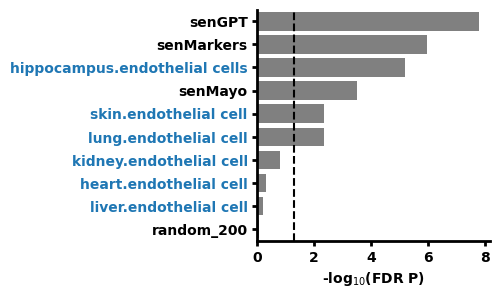

In [21]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/S6B_real.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S6B_real.svg', bbox_inches = 'tight')

plt.show()

In [46]:
res = do_DE('HUVEC', 'IR+', 'IR-')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 5.59 seconds.

Fitting dispersion trend curve...
... done in 3.46 seconds.

Fitting MAP dispersions...
... done in 5.27 seconds.

Fitting LFCs...
... done in 4.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.98 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                    baseMean  log2FoldChange     lfcSE       stat  \
Tracking_ID                                                         
ENSG00000000003  7227.243303        0.501590  0.040691  12.326804   
ENSG00000000005     8.505335        3.015880  1.028256   2.933006   
ENSG00000000419  6244.170638       -0.310438  0.039855  -7.789265   
ENSG00000000457  2169.347225       -0.179754  0.066274  -2.712287   
ENSG00000000460  3227.468889       -0.635238  0.062642 -10.140744   
...                      ...             ...       ...        ...   
ENSG00000273487     0.365192        2.072997  4.319529   0.479913   
ENSG00000273488    61.680091       -0.091249  0.314637  -0.290013   
ENSG00000273489  2122.548046        0.251032  0.063453   3.956163   
ENSG00000273492    12.464470        0.178665  0.800688   0.223139   
ENSG00000273493     0.346441        2.004471  4.325197   0.463440   

                       pvalue          padj

In [707]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2023-05-02 15:28:27,054 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,intestine.plasma cell,0.000000,0.490715,2.026471
1,senMarkers,0.000000,0.564259,1.940805
2,blood.monocyte,0.000000,0.538467,1.966322
6,lung.type ii pneumocyte,0.005291,0.453034,1.780064
7,blood.nk cell,0.005585,0.421874,1.714363
8,liver.macrophage,0.006283,0.473121,1.717765
9,hippocampus.endothelial cells,0.006349,0.459463,1.756423
10,heart.fibroblast,0.007055,0.542201,1.742667
11,senGPT,0.007181,0.478235,1.730483
12,senMayo,0.027513,0.409170,1.508649


In [47]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

In [48]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res[(enr_res.Term.str.contains('endoth')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
17,gs_ind_0,hippocampus.endothelial cells,28/135,9.846130e-08,0.000002,3.672598,59.252237,ITGB4;EFEMP1;CEBPD;IL18R1;FOXO4;EYS;CORIN;PLD1...
42,gs_ind_0,senMarkers,15/77,1.877696e-04,0.001244,3.414360,29.296217,IL18;FOXO4;TIMP2;CXCL11;CCL2;MMP19;IL15;IRF7;C...
45,gs_ind_0,skin.endothelial cell,48/481,5.184720e-03,0.021138,1.546323,8.136811,EPB41L1;ELMOD1;ACKR4;TTBK2;BATF2;PLD1;FAM171B;...
41,gs_ind_0,senGPT,12/84,1.128402e-02,0.039870,2.368153,10.619667,FOXO4;TIMP2;CXCL6;GDF15;ICAM1;MMP19;BMP4;CDKN1...
34,gs_ind_0,lung.endothelial cell,16/135,2.142652e-02,0.063089,1.897196,7.291162,ZFP14;ZNF471;TNFSF13B;CD69;RNASE6;COL5A1;CADM3...
43,gs_ind_0,senMayo,12/96,2.972495e-02,0.074959,2.030729,7.139575,IL18;CSF1;FAS;TIMP2;TNFRSF10C;GDF15;IL32;ICAM1...
27,gs_ind_0,liver.endothelial cell,3/18,1.198926e-01,0.219114,3.092100,6.558834,LRP1;CFHR1;TM7SF2
24,gs_ind_0,kidney.endothelial cell,4/49,4.305984e-01,0.600571,1.353300,1.140263,MAP1LC3A;ERO1B;GDF15;CFH
8,gs_ind_0,heart.endothelial cell,2/40,7.668000e-01,0.967629,0.887703,0.235711,MAP1LC3A;SMAD7
40,gs_ind_0,random_200,7/200,9.851472e-01,1.000000,0.527762,0.007898,ADAMTSL5;LINC00924;GSTM4;ITGB8-AS1;NFATC4;AC09...


### Fig 6F

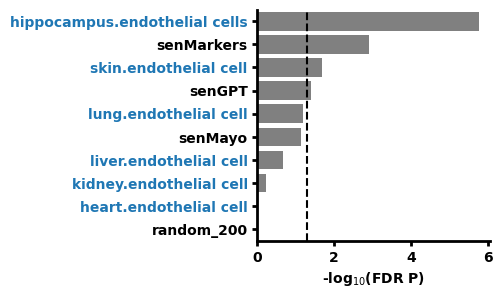

In [49]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/6F.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/6F.svg', bbox_inches = 'tight')


plt.show()

In [50]:
res = do_DE('WI-38', 'IR+', 'IR-')

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 7.33 seconds.

Fitting dispersion trend curve...
... done in 3.54 seconds.

Fitting MAP dispersions...
... done in 7.82 seconds.

Fitting LFCs...
... done in 7.36 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.30 seconds.



Log2 fold change & Wald test p-value: Treatment IR+ vs IR-
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Tracking_ID                                                                   
ENSG00000000003  11620.442396        0.982857  0.466462  2.107049  0.035113   
ENSG00000000005      3.184950       -4.486464  3.424241 -1.310207  0.190126   
ENSG00000000419   5009.686769        0.874902  0.595961  1.468051  0.142090   
ENSG00000000457   2811.938484       -0.519870  0.235248 -2.209880  0.027113   
ENSG00000000460   2269.326872       -1.064043  0.470632 -2.260883  0.023766   
...                       ...             ...       ...       ...       ...   
ENSG00000273487     11.841823        2.276890  1.698056  1.340881  0.179959   
ENSG00000273488     88.114572       -0.540016  0.927097 -0.582481  0.560243   
ENSG00000273489   2260.144104       -0.012418  0.319329 -0.038889  0.968979   
ENSG00000273492      9.449322       -1.707258  1.479572 -1.153887  0.248

In [711]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

2023-05-02 15:33:37,253 [WARNING] Duplicated values found in preranked stats: 0.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,senMayo,0.000000,0.679313,2.715059
1,heart.fibroblast,0.000000,0.616202,2.126785
2,senMarkers,0.000000,0.674192,2.547623
3,senGPT,0.000000,0.674639,2.563830
4,heart.neuronal cell,0.002127,0.485326,1.853790
5,blood.monocyte,0.004052,0.456322,1.795561
6,lung.type ii pneumocyte,0.004124,0.423916,1.767922
7,kidney.endothelial cell,0.004368,0.494354,1.755868
8,heart.myeloid cell,0.004862,0.635648,1.706557
9,blood.nk cell,0.005065,0.390683,1.714027


In [51]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res = enr_res[(enr_res.Term.str.contains('ibroblast')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
44,gs_ind_0,senMayo,38/109,1.386186e-21,7.485407e-20,9.930018,476.916241,IGFBP4;EREG;CCL7;ANGPTL4;PLAU;SPX;IGFBP2;CCL13...
43,gs_ind_0,senMarkers,31/85,1.597856e-18,4.314211e-17,10.608702,434.722014,IGFBP4;EREG;CCL7;PLAU;IGFBP2;CXCL3;ANG;CCL2;CX...
42,gs_ind_0,senGPT,27/85,1.367843e-14,2.462118e-13,8.600225,274.544618,CHEK2;IGFBP4;CCND3;IGFBP2;VCAM1;CXCL3;CCL2;FGF...
10,gs_ind_0,heart.fibroblast,10/48,1.668838e-04,7.509773e-04,4.929128,42.874599,BST2;TMEM100;ATP6AP2;RNASE4;APOE;IFI27;HLA-B;G...
36,gs_ind_0,lung.fibroblast,111/1706,1.213025e-02,2.426051e-02,1.278518,5.640888,NDNF;PEBP4;MYLIP;C16orf89;OMG;MPZL3;F8;EFCC1;A...
47,gs_ind_0,skin.fibroblast,104/1866,2.865772e-01,4.072412e-01,1.070370,1.337692,CHEK2;ARHGAP20;CDK18;TPD52L1;SMAD5-AS1;MANBA;P...
41,gs_ind_0,random_200,9/199,7.273151e-01,8.015309e-01,0.894849,0.284916,AKR1C1;PRRG1;F11;SLC12A7;AC016590.1;AC090337.1...


### Fig 6G

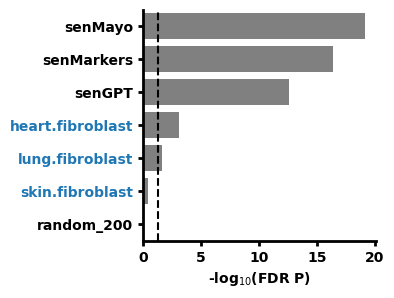

In [52]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/6G.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/6G.svg', bbox_inches = 'tight')


plt.show()

In [3]:
res = do_DE('WI-38', 'Dox+', 'Dox-')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

In [300]:
res = do_DE('WI-38', 'HRAS(G12v)', 'EV')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

enr_res = gsea_df(pre_res)
enr_res[enr_res.es > 0]

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 18.30 seconds.

Fitting dispersion trend curve...
... done in 22.62 seconds.

Fitting MAP dispersions...
... done in 19.64 seconds.

Fitting LFCs...
... done in 17.13 seconds.

Refitting 22 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 5.16 seconds.

Log2 fold change & Wald test p-value: Treatment HRAS(G12v) vs EV


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Tracking_ID,,,,,,
ENSG00000000003,11620.442396,0.236693,0.467638,0.506146,0.612754,0.820641
ENSG00000000005,3.184950,-2.155387,3.555996,-0.606127,0.544430,NaN
ENSG00000000419,5009.686769,1.093332,0.596372,1.833307,0.066757,0.223792
ENSG00000000457,2811.938484,0.068227,0.238879,0.285614,0.775174,0.906139
ENSG00000000460,2269.326872,-0.859935,0.473580,-1.815818,0.069398,0.229640
...,...,...,...,...,...,...
ENSG00000273487,11.841823,-0.008113,1.890601,-0.004291,0.996576,NaN
ENSG00000273488,88.114572,-0.431294,0.940922,-0.458373,0.646684,0.839963
ENSG00000273489,2260.144104,0.315578,0.320939,0.983298,0.325461,0.594435


2023-04-25 20:38:15,377 [WARNING] Duplicated values found in preranked stats: 0.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,fdr,es,nes
0,senGPT,0.000000,0.601486,2.270671
1,senMayo,0.000000,0.662942,2.671585
2,kidney.macrophage,0.000000,0.494342,2.177176
3,heart.pericyte,0.000826,0.564507,1.957368
4,heart.endothelial cell,0.001032,0.588723,1.965149
5,blood.nk cell,0.006651,0.397405,1.750329
6,kidney.endothelial cell,0.008650,0.477813,1.710226
7,heart.neuronal cell,0.020814,0.425249,1.593405
8,lung.macrophage,0.021865,0.379464,1.570189
9,intestine.epithelial cell,0.022844,0.356390,1.547223


In [54]:
res = do_DE('WI-38', 'RS', 'Control')
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]


user_set = filter_gene_sets(human_sets, rank.Symbol.values)

# pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

# enr_res = gsea_df(pre_res)
# enr_res[enr_res.es > 0]

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 7.58 seconds.

Fitting dispersion trend curve...
... done in 3.43 seconds.

Fitting MAP dispersions...
... done in 7.78 seconds.

Fitting LFCs...
... done in 7.35 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.46 seconds.



Log2 fold change & Wald test p-value: Treatment RS vs Control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Tracking_ID                                                                   
ENSG00000000003  11620.442396        0.070244  0.466472  0.150586  0.880302   
ENSG00000000005      3.184950        4.791935  3.407952  1.406104  0.159693   
ENSG00000000419   5009.686769       -0.108486  0.595877 -0.182060  0.855535   
ENSG00000000457   2811.938484       -0.374467  0.235078 -1.592948  0.111172   
ENSG00000000460   2269.326872       -0.525230  0.470639 -1.115993  0.264425   
...                       ...             ...       ...       ...       ...   
ENSG00000273487     11.841823       -0.407330  1.629289 -0.250005  0.802584   
ENSG00000273488     88.114572        0.100537  0.911809  0.110261  0.912203   
ENSG00000273489   2260.144104       -0.196752  0.318542 -0.617664  0.536797   
ENSG00000273492      9.449322       -1.651085  1.386738 -1.190625  0.

In [55]:
user_set = filter_gene_sets(human_sets, rank.Symbol.tolist())
user_set['random_200'] = random.choices(rank.Symbol, k = 200)


enr = gp.enrichr(gene_list= res[(res.padj < 0.05) & (res.log2FoldChange > 0.5)].dropna().Symbol.tolist(),
                 gene_sets= user_set,
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = rank.Symbol.tolist()
                )

enr_res = enr.results.sort_values('Adjusted P-value')

enr_res = enr_res = enr_res[(enr_res.Term.str.contains('ibroblast')) | (enr_res.Term.str.startswith('sen')) |\
        (enr_res.Term.str.contains('random'))]

enr_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
44,gs_ind_0,senMayo,26/109,2.343010e-14,1.265225e-12,8.413062,264.041876,MMP1;EREG;MMP10;ANGPTL4;PLAU;SPX;CSF2;SERPINE1...
42,gs_ind_0,senGPT,14/85,2.880865e-06,3.889167e-05,5.308528,67.723121,CCND3;BMP6;IGFBP7;MMP10;CCND2;STAT1;EDN1;VCAM1...
43,gs_ind_0,senMarkers,14/85,2.880865e-06,3.889167e-05,5.308528,67.723121,CXCL14;PLAT;EREG;IGFBP7;MMP10;TGFB2;CXCL11;PLA...
10,gs_ind_0,heart.fibroblast,6/48,8.458927e-03,2.283910e-02,3.973753,18.964866,TMEM100;CLIC1;PPDPF;AUP1;GRN;FIBIN
36,gs_ind_0,lung.fibroblast,76/1706,5.845902e-02,1.052262e-01,1.231649,3.497179,MSX1;FOXF2;KIAA1671;MDGA1;GREB1;USP18;TANGO2;K...
47,gs_ind_0,skin.fibroblast,75/1866,2.567157e-01,3.465662e-01,1.097127,1.491858,SERPIND1;KIAA1671;KIF13B;SPR;TANGO2;CHRNA1;TME...
41,gs_ind_0,random_200,4/200,9.425902e-01,9.902773e-01,0.589944,0.034880,ADCY1;TAP2;LINC00452;TSPAN12


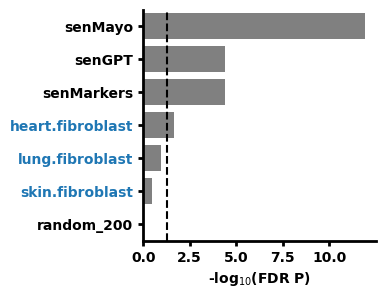

In [56]:
grapher = enr_res.copy()
grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/6H.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/6H.svg', bbox_inches = 'tight')

plt.show()

# Mouse lung senolytic GSE180750 Fig 6E

In [57]:
#this study only put their sig DE genes up so getting background from something else
m_bacground = pd.read_csv('../data/bulk_RNAseq/senMayo_data/raw_gene_counts_INK_ATTAC.csv')['GeneName'].tolist()

In [58]:
ls ../data/bulk_RNAseq/GSE180750_mouse_lung_senolytic/

GSE180750_data3-sig_B_vs_C.xlsx  GSE180750_data3-sig_H_vs_C.xlsx
GSE180750_data3-sig_H_vs_B.xlsx


In [59]:
'''
vehicle treatment C
bleomycin instillation B
homoharringtonine administration H

'''

'\nvehicle treatment C\nbleomycin instillation B\nhomoharringtonine administration H\n\n'

In [62]:
res = pd.read_excel('../data/bulk_RNAseq/GSE180750_mouse_lung_senolytic/GSE180750_data3-sig_H_vs_B.xlsx')


res = res[['ProbeID', 'Gene_Symbol', 'H/B.fc', 'H/B.adj.pval']]

res.sort_values('H/B.fc', ascending = False)

,ProbeID,Gene_Symbol,H/B.fc,H/B.adj.pval
21,17284512,Ighv1-9,7.810600,0.000000e+00
79,17459324,Igkv1-117,6.120658,7.093972e-11
78,17459309,Igkv14-126,5.869198,1.235607e-07
18,17284349,Ighm,5.543204,1.049192e-11
49,17384374,Hc,4.645788,4.590217e-12
...,...,...,...,...
102,17503937,Mt2,-4.983203,2.371028e-09
40,17357640,Ms4a4a,-5.173916,1.678747e-13
33,17326075,Retnlg,-5.369694,1.842510e-11
32,17325324,Stfa2l1,-6.493442,3.385368e-23


In [63]:
import random

In [64]:
user_set = mouse_sets.copy()
user_set['random_200'] = random.choices(m_bacground, k = 200)

#user_set = filter_gene_sets(mouse_sets, m_background)


enr = gp.enrichr(gene_list= res[res['H/B.fc'] < 0].Gene_Symbol.tolist(),
                 gene_sets= user_set,
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = m_bacground
                )

In [65]:
#if random200 doesn't have at least one value overlap it wont show up
[x for x in user_set['random_200'] if x in res[res['H/B.fc'] < 0].Gene_Symbol.tolist()]

['Cldn4']

In [66]:
enr.results[enr.results.Term.str.startswith('ra')]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
40,gs_ind_0,random_200,1/200,0.256717,0.262687,5.093067,6.925462,Cldn4


In [67]:
grapher = enr.results.sort_values('Adjusted P-value')

In [68]:
grapher = grapher[(grapher.Term.str.startswith('sen')) |\
        (grapher.Term.str.startswith('Lung')) |\
        (grapher.Term.str.startswith('Trachea')) |\
       (grapher.Term.str.startswith('random'))]


grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

In [69]:
grapher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,nlogp
28,gs_ind_0,Lung.fibroblast,14/755,4.597276e-12,1.011401e-10,16.446105,429.334743,Retnlg;Dpep2;Gda;Ms4a6d;Ccl2;C1qb;C1qc;Vsig4;C...,9.995077
38,gs_ind_0,Trachea.fibroblast,13/720,4.054091e-11,5.946000e-10,15.748719,376.846515,Dpep2;Ms4a6d;C1qb;AA467197;C1qc;Vsig4;Cldn4;It...,9.225775
39,gs_ind_0,Trachea.macrophage,15/1817,4.794436e-08,2.636940e-07,7.193855,121.239660,Retnlg;Lox;Serpina3n;Fst;Vsig4;Cldn4;Serpina3m...,6.578900
27,gs_ind_0,Lung.alveolar macrophage,6/154,1.164186e-07,5.691576e-07,32.221848,514.456397,Stfa2l1;AA467197;C1qc;Itgam;Il1r2;Cd177,6.244767
41,gs_ind_0,senGPT,5/93,2.835282e-07,1.247524e-06,45.042919,679.064980,Lox;Ccl2;Col1a1;Serpine1;Timp1,5.903951
43,gs_ind_0,senMayo,4/112,2.395974e-05,7.278046e-05,29.549492,314.381055,Ccl2;Spp1;Pappa;Serpine1,4.137985
42,gs_ind_0,senMarkers,3/110,5.946686e-04,1.308271e-03,22.820079,169.496284,Ccl2;Timp1;Serpine1,2.883302
37,gs_ind_0,Trachea.basal cell,5/551,1.350259e-03,2.475474e-03,7.216765,47.684481,Serpina3n;Ms4a6d;Vsig4;C1qc;Pla1a,2.606342
40,gs_ind_0,random_200,1/200,2.567167e-01,2.626869e-01,5.093067,6.925462,Cldn4,0.580562


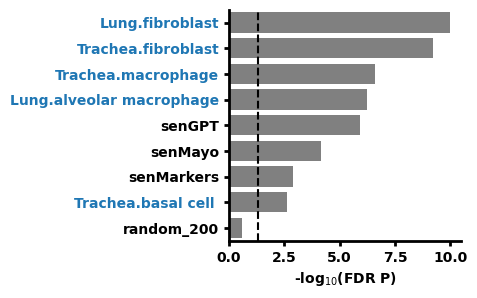

In [71]:
plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')


plt.savefig('figures/6E.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/6E.svg', bbox_inches = 'tight')


plt.show()

# Aged mouse muscle + sen GSE184348 Fig 6A

In [72]:
ls ../data/bulk_RNAseq/GSE184348_mouse_muscle_senolytic/

GSE184348_Muscle_RNAseq_raw_counts.xlsx


In [73]:
counts = pd.read_excel('../data/bulk_RNAseq/GSE184348_mouse_muscle_senolytic/GSE184348_Muscle_RNAseq_raw_counts.xlsx')

In [74]:
symbol_map = dict(zip(counts.GeneId, counts.GeneName))

In [75]:
counts = counts.drop(columns = 'GeneName').set_index('GeneId')

In [76]:
counts = counts[counts.sum(axis = 1) > 0]

In [77]:
m_background = counts.index.map(symbol_map).tolist() #symbol_background for enr

In [78]:
counts = counts.T
counts

GeneId,ENSMUSG00000051951,ENSMUSG00000089699,ENSMUSG00000103147,ENSMUSG00000103161,ENSMUSG00000102331,ENSMUSG00000025900,ENSMUSG00000104123,ENSMUSG00000025902,ENSMUSG00000104238,ENSMUSG00000102269,...,ENSMUSG00000101142,ENSMUSG00000075359,ENSMUSG00000099793,ENSMUSG00000096438,ENSMUSG00000099734,ENSMUSG00000095134,ENSMUSG00000095366,ENSMUSG00000096768,ENSMUSG00000099871,ENSMUSG00000096850
Muscle-Young-1,2,4,0,0,1,29,2,232,2,5,...,1,8,0,10,0,9,3,0,5,2
Muscle-Young-2,3,1,1,0,4,21,0,242,0,5,...,0,12,0,14,0,10,0,4,2,3
Muscle-Young-3,1,3,0,0,2,15,0,214,0,4,...,0,9,0,5,0,2,1,2,2,2
Muscle-Young-4,2,0,0,0,1,31,0,217,0,2,...,0,12,0,5,0,1,1,4,0,2
Muscle-Old-1,2,1,1,0,3,21,0,333,1,3,...,0,7,0,7,0,7,1,3,5,1
Muscle-Old-2,0,0,0,1,3,49,0,284,2,1,...,0,9,0,10,0,4,1,2,2,1
Muscle-Old-3,2,0,0,0,1,17,0,224,0,6,...,0,6,0,9,0,4,0,6,1,0
Muscle-Old-4,1,0,0,0,1,24,0,266,0,8,...,0,3,0,12,0,6,0,1,2,0
Muscle-DQ-1,1,0,0,0,7,16,0,212,1,5,...,0,6,1,11,0,5,1,9,5,1
Muscle-DQ-2,1,2,0,0,1,49,0,244,0,1,...,0,7,0,17,0,15,5,3,7,2


In [79]:
def smol_map(x):
    if 'Young' in x:
        return 'Young'
    elif 'Old' in x:
        return 'Old'
    else:
        return 'DQ'

metadata = pd.DataFrame(counts.index, columns = ['Sample'])

metadata['Treatment'] = metadata.Sample.map(smol_map)

metadata = metadata.set_index('Sample')

In [80]:
metadata

,Treatment
Sample,
Muscle-Young-1,Young
Muscle-Young-2,Young
Muscle-Young-3,Young
Muscle-Young-4,Young
Muscle-Old-1,Old
Muscle-Old-2,Old
Muscle-Old-3,Old
Muscle-Old-4,Old
Muscle-DQ-1,DQ


In [82]:

dds = DeseqDataSet(
counts=counts,
metadata=metadata,
design_factors="Treatment",
refit_cooks=True,
)

dds.deseq2()


stat_res = DeseqStats(dds,contrast=('Treatment', 'Old', 'DQ'))
stat_res.summary()

res = stat_res.results_df

res = res.sort_values('stat', ascending = False)

res['Symbol'] = res.index.map(symbol_map)

res = res[res.baseMean > 10]

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.59 seconds.

Fitting dispersion trend curve...
... done in 2.42 seconds.

Fitting MAP dispersions...
... done in 2.51 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.90 seconds.



Log2 fold change & Wald test p-value: Treatment Old vs DQ
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneId                                                                       
ENSMUSG00000051951  1.498302       -0.051328  1.175106 -0.043679  0.965160   
ENSMUSG00000089699  1.149603       -1.769196  1.838655 -0.962223  0.335937   
ENSMUSG00000103147  0.139367        0.670110  4.127966  0.162334  0.871043   
ENSMUSG00000103161  0.075219        0.670112  4.127966  0.162335  0.871042   
ENSMUSG00000102331  2.362083       -0.791581  0.915504 -0.864640  0.387236   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000095134  5.660532       -0.492250  0.733316 -0.671266  0.502051   
ENSMUSG00000095366  1.168347       -1.888963  1.583150 -1.193168  0.232804   
ENSMUSG00000096768  3.131894       -0.345696  0.937020 -0.368931  0.712179   
ENSMUSG00000099871  3.047765       -1.028207  0.814743 -1.262002  0.206948   
ENSMUS

In [83]:
rank = res[['Symbol', 'stat']].rename(columns = {'stat': 'Rank'}).dropna()

#drop duplicates but keep higher abs value row
rank['abs_rank'] = rank['Rank'].abs()
rank = rank.loc[rank.groupby('Symbol')['abs_rank'].idxmax()]\
    .sort_values('Rank', ascending = False)[['Symbol', 'Rank']]

rank['Symbol'] = rank['Symbol'].astype(str)

user_set = filter_gene_sets(mouse_sets, rank.Symbol.values)

# pre_res = gp.prerank(rnk = rank, gene_sets = user_set, seed = 6)

# enr_res = gsea_df(pre_res)
# enr_res[enr_res.es > 0]

In [114]:
user_set['random_200'] = random.choices(m_bacground, k = 200) #need at least one overlap or wont show up in df


enr = gp.enrichr(gene_list= res[(res['pvalue'] < 0.05) & (res.stat > 0)].Symbol.tolist(),
                 gene_sets= user_set,
                 organism='mouse', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = m_bacground
                )

In [115]:
grapher = enr.results.sort_values('Adjusted P-value')

In [116]:
grapher = grapher[(grapher.Term.str.startswith('sen')) |\
        (grapher.Term.str.contains('myocyte')) |\
        (grapher.Term.str.startswith('Limb')) |\
       (grapher.Term.str.startswith('random'))]


grapher['nlogp'] = -np.log10(grapher['Adjusted P-value'])

In [117]:
grapher

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,nlogp
8,gs_ind_0,Heart_and_Aorta.myocyte,11/434,0.000005,0.000032,6.278467,76.520411,Dlg2;Gm13154;Aim2;Ttc9;Rassf10;Rin1;Kctd7;E230...,4.490077
38,gs_ind_0,senMarkers,4/74,0.000359,0.000846,14.336370,113.700459,Plau;Rb1;Cxcl1;Timp1,3.072739
37,gs_ind_0,senGPT,4/74,0.000359,0.000846,14.336370,113.700459,Edn1;Rb1;Cxcl1;Timp1,3.072739
20,gs_ind_0,Limb_Muscle.skeletal muscle satellite cell,3/37,0.000625,0.001191,22.686430,167.366016,Ifi203;Sybu;Mx2,2.924107
19,gs_ind_0,Limb_Muscle.macrophage,5/175,0.001227,0.002135,7.266362,48.705359,Clec14a;Gm14005;Tnfrsf23;Ckap2;Rrm2,2.670680
39,gs_ind_0,senMayo,3/82,0.006145,0.009453,9.834763,50.080446,Plau;Edn1;Cxcl1,2.024422
21,gs_ind_0,Limb_Muscle.smooth muscle cell,1/51,0.205829,0.216662,6.571534,10.387678,Rassf10,0.664216
36,gs_ind_0,random_200,1/200,0.595586,0.595586,1.657711,0.859041,Slc16a12,0.225055


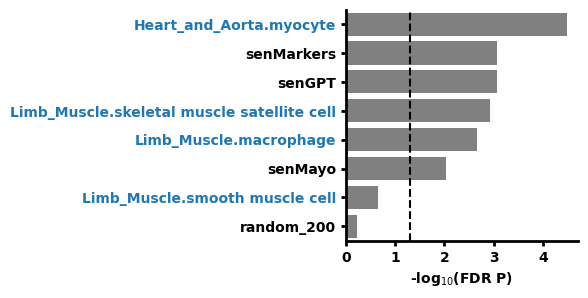

In [119]:
plt.figure(figsize = (3,3))
ax = sns.barplot(data = grapher, x = 'nlogp', y = 'Term', color = 'grey')

plt.axvline(-np.log10(0.05), ls = '--', color = 'k')


ax.set_ylabel('')


ax.set_xlabel('-log$_{10}$(FDR P)')

# Make ticks thicker
ax.tick_params(width=2)

# Make tick labels bolder
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_fontweight('bold')


for label in ax.get_yticklabels():
    if '.' in label.get_text():
        label.set_color('tab:blue')

plt.savefig('figures/S6B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S6B.svg', bbox_inches = 'tight')

plt.show()